In [71]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## Machine learning is a game of two parts:

1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation
   To showcase this, let's create some known data using the linear regression formula.
   We'll use a linear regression formula to make a straight line with _known_ **parameters**


In [72]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [73]:
len(X), len(y)

(50, 50)

### Splitting the data into training and test sets (one of the most important concepts in machine learning in general)


In [74]:
train_split = int(0.8 * len(X))  # 80% of the data
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [75]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions if not None.
    """
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    # If predictions are provided, plot them in red
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 14})

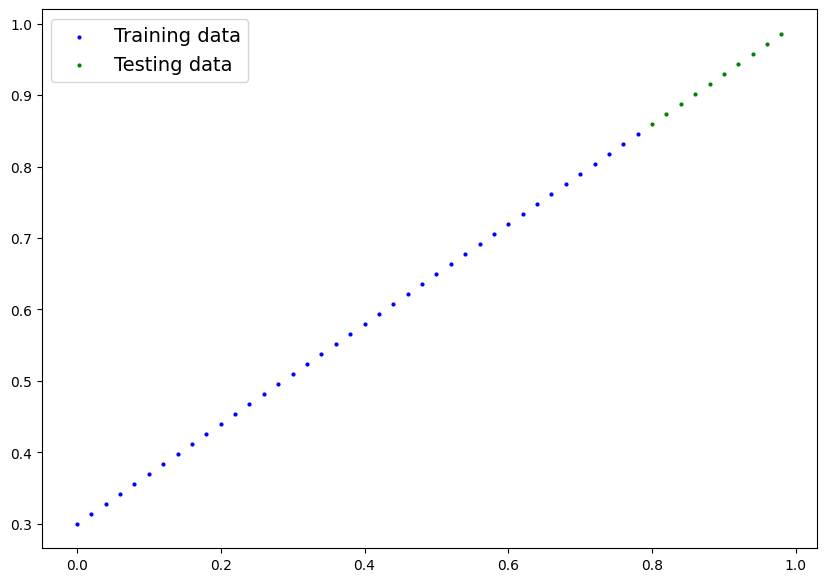

In [76]:
plot_predictions()

## Build model

What the model does:

-   Start with random values (weight and bias)
-   Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

Two main algorithms:

1. Gradient Descent
2. Backpropagation


In [77]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the forward computation of the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.weights + self.bias  # Linear regression equation

In [78]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making prediction using `torch.inference_mode()`


In [79]:
with torch.inference_mode():  # Turn off gradient tracking
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

## Train model

The idea of training is for a model to move from some _unknown_ parameters to _known_ parameters. We do this by showing the model known data and adjusting the parameters until the model's output is close to the known data.

One way to measure how poor or how wrong the model is by using a loss function. The loss function measures the difference between the model's output and the known data.

-   Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:

-   **Loss function**:
    -   Measures how far off the model's prediction is from the actual output
    -   The goal is to minimize the loss function
-   **Optimizer**:
    -   Adjusts the model's parameters to minimize the loss function
    -   One common optimizer is the `Stochastic Gradient Descent (SGD)`
    -   Two important parameters to set in the optimizer are:
        -   `params` - the model parameters we'd like to optimize, for example, `model.parameters()`
        -   `lr` - the learning rate (hyperparameter), which controls the step size of the optimizer. A large learning rate might cause the optimizer to overshoot the minimum, while a small learning rate might cause the optimizer to take too long to converge.

For PyTorch we need:

-   Training loop
-   Test loop


In [80]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

## Training loop and testing loop in PyTorch

0. Loop through the data
1. Forward pass (involves data moving through our model's `forward` method) to make predictions on data - also called forward propagation
2. Calculate loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to update the model parameters based on the gradients to improve the loss (**gradient descent**)


In [81]:
torch.manual_seed(42)

epochs = 180  # Number of loops through the training data

# Track different values during training
epoch_count = []
train_loss_values = []
test_loss_values = []

# Training loop
# 0. Loop through the data multiple times
for eph in range(epochs):
    # Set the model to training mode
    model_0.train()  # Train mode set all params that require gradients to require gradients

    # 1. Forward pass: compute predicted y by passing x to the model
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero gradients
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the model parameters
    loss.backward()  # Calculate the gradients (derivatives of the loss with respect to each parameter or the curve)

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()  # By default how the optimizer changes will accumulate through the loop so we need to zero the gradients (step 3) for the next iteration

    # Testing
    model_0.eval()  # Turn off different settings in the model not needed for evaluation/testing (dropout, batchnorm, etc.)
    with torch.inference_mode():  # Turn off gradient tracking & things behind the scenes that are only needed during training
        # 1. Do the forward pass
        y_test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(y_test_pred, y_test)

    if eph % 10 == 0:
        epoch_count.append(eph)
        train_loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        print(
            f"Epoch {eph} | MAE Train loss: {loss.item()} | MAE Test loss: {test_loss.item()}"
        )

Epoch 0 | MAE Train loss: 0.31288138031959534 | MAE Test loss: 0.48106518387794495
Epoch 10 | MAE Train loss: 0.1976713240146637 | MAE Test loss: 0.3463551998138428
Epoch 20 | MAE Train loss: 0.08908725529909134 | MAE Test loss: 0.21729660034179688
Epoch 30 | MAE Train loss: 0.053148526698350906 | MAE Test loss: 0.14464017748832703
Epoch 40 | MAE Train loss: 0.04543796554207802 | MAE Test loss: 0.11360953003168106
Epoch 50 | MAE Train loss: 0.04167863354086876 | MAE Test loss: 0.09919948130846024
Epoch 60 | MAE Train loss: 0.03818932920694351 | MAE Test loss: 0.08886633068323135
Epoch 70 | MAE Train loss: 0.03476089984178543 | MAE Test loss: 0.0805937647819519
Epoch 80 | MAE Train loss: 0.03132382780313492 | MAE Test loss: 0.07232122868299484
Epoch 90 | MAE Train loss: 0.02788740023970604 | MAE Test loss: 0.06473556160926819
Epoch 100 | MAE Train loss: 0.024458957836031914 | MAE Test loss: 0.05646304413676262
Epoch 110 | MAE Train loss: 0.021020209416747093 | MAE Test loss: 0.048190496

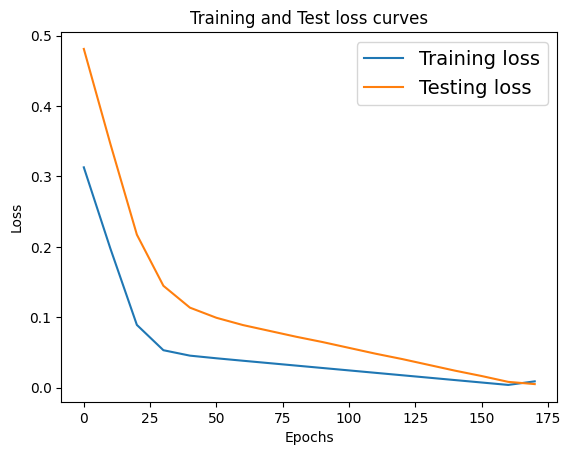

In [82]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Training loss")
plt.plot(epoch_count, test_loss_values, label="Testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(prop={"size": 14})

In [83]:
{"weights": weight, "bias": bias}, model_0.state_dict()

({'weights': 0.7, 'bias': 0.3},
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))

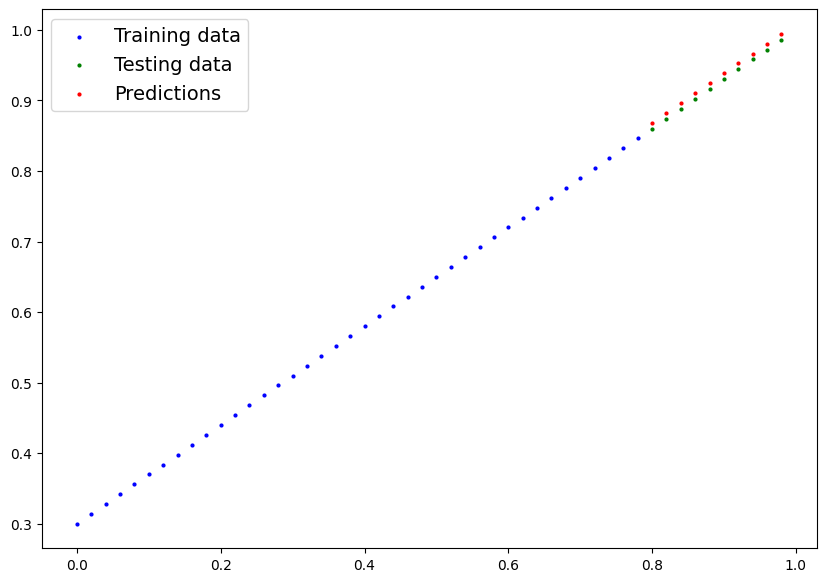

In [84]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)

## Saving model in PyTorch

Three main methods to save and load models in PyTorch:

1. `torch.save(model.state_dict(), PATH)` - allows to save a PyTorch object in Python's pickle format
2. `torch.load(PATH)` - allows to load a saved PyTorch object from a file
3. `torch.nn.Module.load_state_dict(torch.load(PATH))` - allows to load the saved state dictionary into the model


In [85]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [86]:
!ls -l models

total 8
-rw-r--r--  1 macbook  staff  1680 May  3 14:01 01_pytorch_workflow_model_0.pth


## Loading model in PyTorch

Since we saved the model's state dictionary, we need to create an instance of the model and load the saved `state_dict()` into that.


In [87]:
# Instantiate a new model
model_0_loaded = LinearRegressionModel()

# Load the model state dict
model_0_loaded.load_state_dict(state_dict=torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [88]:
model_0_loaded.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [89]:
model_0_loaded.eval()
with torch.inference_mode():
    y_preds_loaded = model_0_loaded(X_test)

# Compare the predictions from the loaded model with the original model
torch.allclose(y_preds_new, y_preds_loaded)

True

## Putting it all together

All the steps above are put together in the code below.


In [90]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.0.dev20240427'

In [91]:
# Device-agnostic code
dvc = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
dvc

'mps'

### Data preparation

Create data using the linear regression formula of `y = wx + b`


In [92]:
weight = 0.7
bias = 0.3

# Range values
start = 0
end = 1
step = 0.02

# Create X and y tensors (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [93]:
# Split data
train_split = int(0.8 * len(X))  # 80% of the data
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

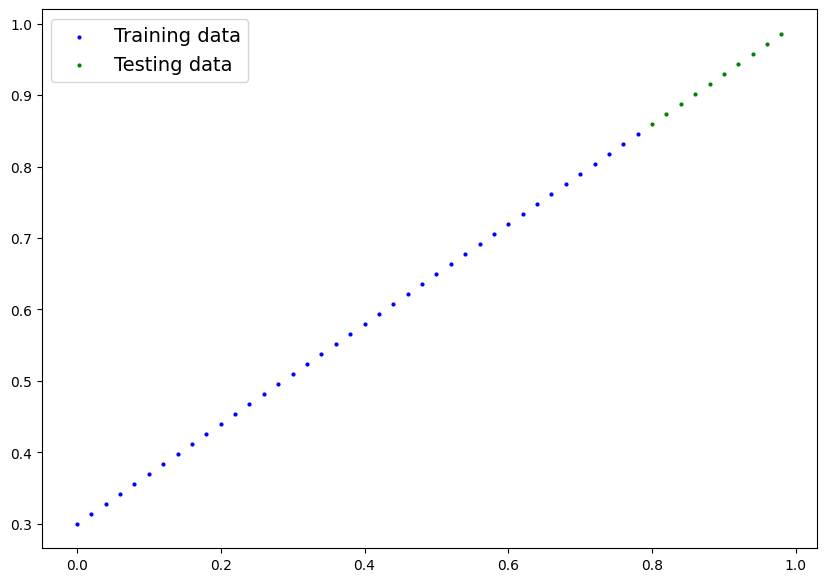

In [94]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### Build Linear Regression model


In [95]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() instead of defining weights and bias: Linear transform, probling layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


# Set the manual seed for reproducibility
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [96]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [97]:
# Set the model to use the target device
model_1.to(dvc)
next(model_1.parameters()).device

device(type='mps', index=0)

### Training the model

For training, we need:

-   Loss function
-   Optimizer
-   Training loop
-   Testing loop


In [98]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [99]:
# Training loop
torch.manual_seed(42)

epochs = 180  # Number of loops through the training data

# Put data on the target device
X_train = X_train.to(dvc)
y_train = y_train.to(dvc)
X_test = X_test.to(dvc)
y_test = y_test.to(dvc)

for eph in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        y_test_pred = model_1(X_test)
        test_loss = loss_fn(y_test_pred, y_test)

    if eph % 10 == 0:
        print(
            f"Epoch {eph} | MAE Train loss: {loss.item()} | MAE Test loss: {test_loss.item()}"
        )

Epoch 0 | MAE Train loss: 0.5551779270172119 | MAE Test loss: 0.5739762783050537
Epoch 10 | MAE Train loss: 0.4399681091308594 | MAE Test loss: 0.4392664134502411
Epoch 20 | MAE Train loss: 0.3247582018375397 | MAE Test loss: 0.30455657839775085
Epoch 30 | MAE Train loss: 0.20954833924770355 | MAE Test loss: 0.16984672844409943
Epoch 40 | MAE Train loss: 0.09433844685554504 | MAE Test loss: 0.03513689711689949
Epoch 50 | MAE Train loss: 0.023886388167738914 | MAE Test loss: 0.04784906655550003
Epoch 60 | MAE Train loss: 0.0199567973613739 | MAE Test loss: 0.04580312594771385
Epoch 70 | MAE Train loss: 0.016517987474799156 | MAE Test loss: 0.0375305712223053
Epoch 80 | MAE Train loss: 0.01308917161077261 | MAE Test loss: 0.029944902285933495
Epoch 90 | MAE Train loss: 0.009653176181018353 | MAE Test loss: 0.02167237363755703
Epoch 100 | MAE Train loss: 0.0062156799249351025 | MAE Test loss: 0.014086711220443249
Epoch 110 | MAE Train loss: 0.00278724217787385 | MAE Test loss: 0.005814164

In [101]:
{"weights": weight, "bias": bias}, model_1.state_dict()

({'weights': 0.7, 'bias': 0.3},
 OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
              ('linear_layer.bias', tensor([0.3025], device='mps:0'))]))

### Making and evaluating predictions


In [102]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

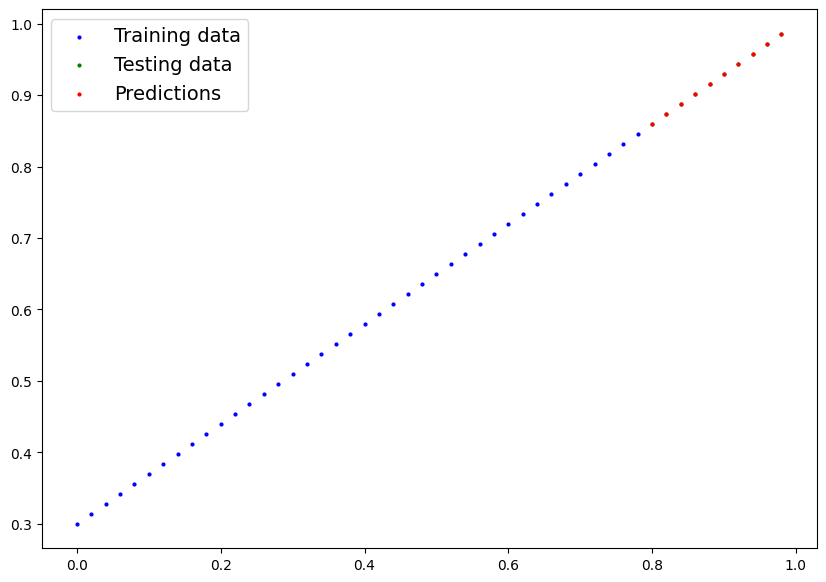

In [103]:
# Plot the predictions
plot_predictions(predictions=y_preds.cpu())

### Saving and loading the model


In [104]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [107]:
# Load the model

# Instantiate a new model
model_1_loaded = LinearRegressionModelV2()

# Load the model state dict
model_1_loaded.load_state_dict(state_dict=torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model on the target device
model_1_loaded.to(dvc)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [108]:
next(model_1_loaded.parameters()).device

device(type='mps', index=0)

In [109]:
model_1_loaded.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

In [110]:
# Evaluate the loaded model
model_1_loaded.eval()
with torch.inference_mode():
    y_preds_loaded = model_1_loaded(X_test)
torch.allclose(y_preds, y_preds_loaded)

True